In [1]:
import numpy as np
import math

from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Representing any optical component as a function of 2x2 Universal Unitary Matrix Operations around a Bloch sphere: 

Macho‐Ortiz, Andrés, Daniel Pérez‐López, and José Capmany. "Optical implementation of 2× 2 universal unitary matrix transformations." Laser & Photonics Reviews 15.7 (2021): 2000473, https://doi.org/10.1002/lpor.202000473.


### Representing any polarization rotation in an optical as function of rotation around the Poincare sphere:

Gordon, J. P., and H. Kogelnik. "PMD fundamentals: Polarization mode dispersion in optical fibers." Proceedings of the National Academy of Sciences 97.9 (2000): 4541-4550, https://doi.org/10.1073/pnas.97.9.4541.

In [2]:
def rotation_rx(angle):
  rx = np.array(
      [
        [np.cos(angle/2), -1j*np.sin(angle/2)], 
        [-1j*np.sin(angle/2), np.cos(angle/2)]
        ]
      )
  return rx

def rotation_ry(angle):
  ry = np.array(
      [
        [np.cos(angle/2), -np.sin(angle/2)], 
        [np.sin(angle/2), np.cos(angle/2)]
        ]
      )
  return ry

def rotation_rz(angle):
  rz = np.array(
      [
        [np.exp(-1j*angle/2), 0], 
        [0, np.exp(1j*angle/2)]
        ]
      )
  return rz

def rotation_delta(angle):
  return np.exp(1j*angle)

def jones_matrix(_rotation):
    _jones_matrix_rx = rotation_rx(_rotation[0])
    _jones_matrix_ry = rotation_ry(_rotation[1])
    _jones_matrix_rz = rotation_rz(_rotation[2])
    _jones_matrix_global_phase = rotation_delta(_rotation[3])
    jones_matrix = _jones_matrix_global_phase * _jones_matrix_rx @ _jones_matrix_ry @ _jones_matrix_rz 
    return jones_matrix

# Polarization Receivers on TX and RX

In [3]:
mzi_1 = rotation_ry(0.0)
ps_1 = rotation_rz(0.0)

mzi_2 = rotation_ry(0.0)
ps_2 = rotation_rz(0.0)

fiber_1 = jones_matrix(np.random.uniform(-np.pi, np.pi, 4))
fiber_2 = jones_matrix(np.random.uniform(-np.pi, np.pi, 4))

In [4]:
print("Initial states")
print("MZI 1:\n", mzi_1)
print("Phase Shifter 1:\n", ps_1)
print("MZI 2:\n", mzi_2)
print("Phase Shifter 2:\n", ps_2)
print("Fiber 1:\n", fiber_1)
print("Fiber 2:\n", fiber_2)

Initial states
MZI 1:
 [[ 1. -0.]
 [ 0.  1.]]
Phase Shifter 1:
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
MZI 2:
 [[ 1. -0.]
 [ 0.  1.]]
Phase Shifter 2:
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Fiber 1:
 [[ 0.36009285+0.68035537j -0.26303578+0.58160286j]
 [ 0.32179795+0.55126744j  0.28776948-0.71396009j]]
Fiber 2:
 [[-0.24033586+0.38331655j -0.70674061-0.54389779j]
 [-0.69898073+0.55383485j  0.24573091+0.37988054j]]


In [5]:
def objective_reverse(phases, input_state, params):
    """
    The objective function here is just maximize the received signal in the
    RX of port 2
    """
    phase_1 = phases[0]  # phase shifter setting
    theta_1 = phases[1]  # MZI setting
    phase_2 = phases[2]  # phase shifter setting
    theta_2 = phases[3]  # MZI setting

    mzi_1 = rotation_ry(phase_1)
    ps_1 = rotation_rz(theta_1)

    mzi_2 = rotation_ry(phase_2)
    ps_2 = rotation_rz(theta_2)

    output_state_reverse = mzi_1.T @ ps_1.T @ fiber_1.T @ fiber_2.T @ ps_2.T @ mzi_2.T @ input_state
    
    I_top_port = np.abs(output_state_reverse[0])**2
    I_bottom_port = np.abs(output_state_reverse[1])**2

    intensities = [I_top_port, I_bottom_port]
    curr_params = [phase_1, theta_1, phase_2, theta_2] + [output_state_reverse[0], output_state_reverse[1]] + intensities
    params.append(curr_params)

    return -1.0 * intensities[-1]  # maximize the receiving port power

In [6]:
input_state_reverse = np.array([1.0, 0.0])

bounds = [(-math.pi, math.pi), (-math.pi, math.pi), (-math.pi, math.pi), (-math.pi, math.pi)]

opts = {'fatol': 1e-6}
params = []
result = minimize(objective_reverse, (0.0, 0.0, 0.0, 0.0),
                  bounds=bounds,
                  args=(input_state_reverse, params),
                  method='Nelder-Mead',
                  options=opts)

/Users/sashwyn06/miniconda3/envs/lmphoton/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


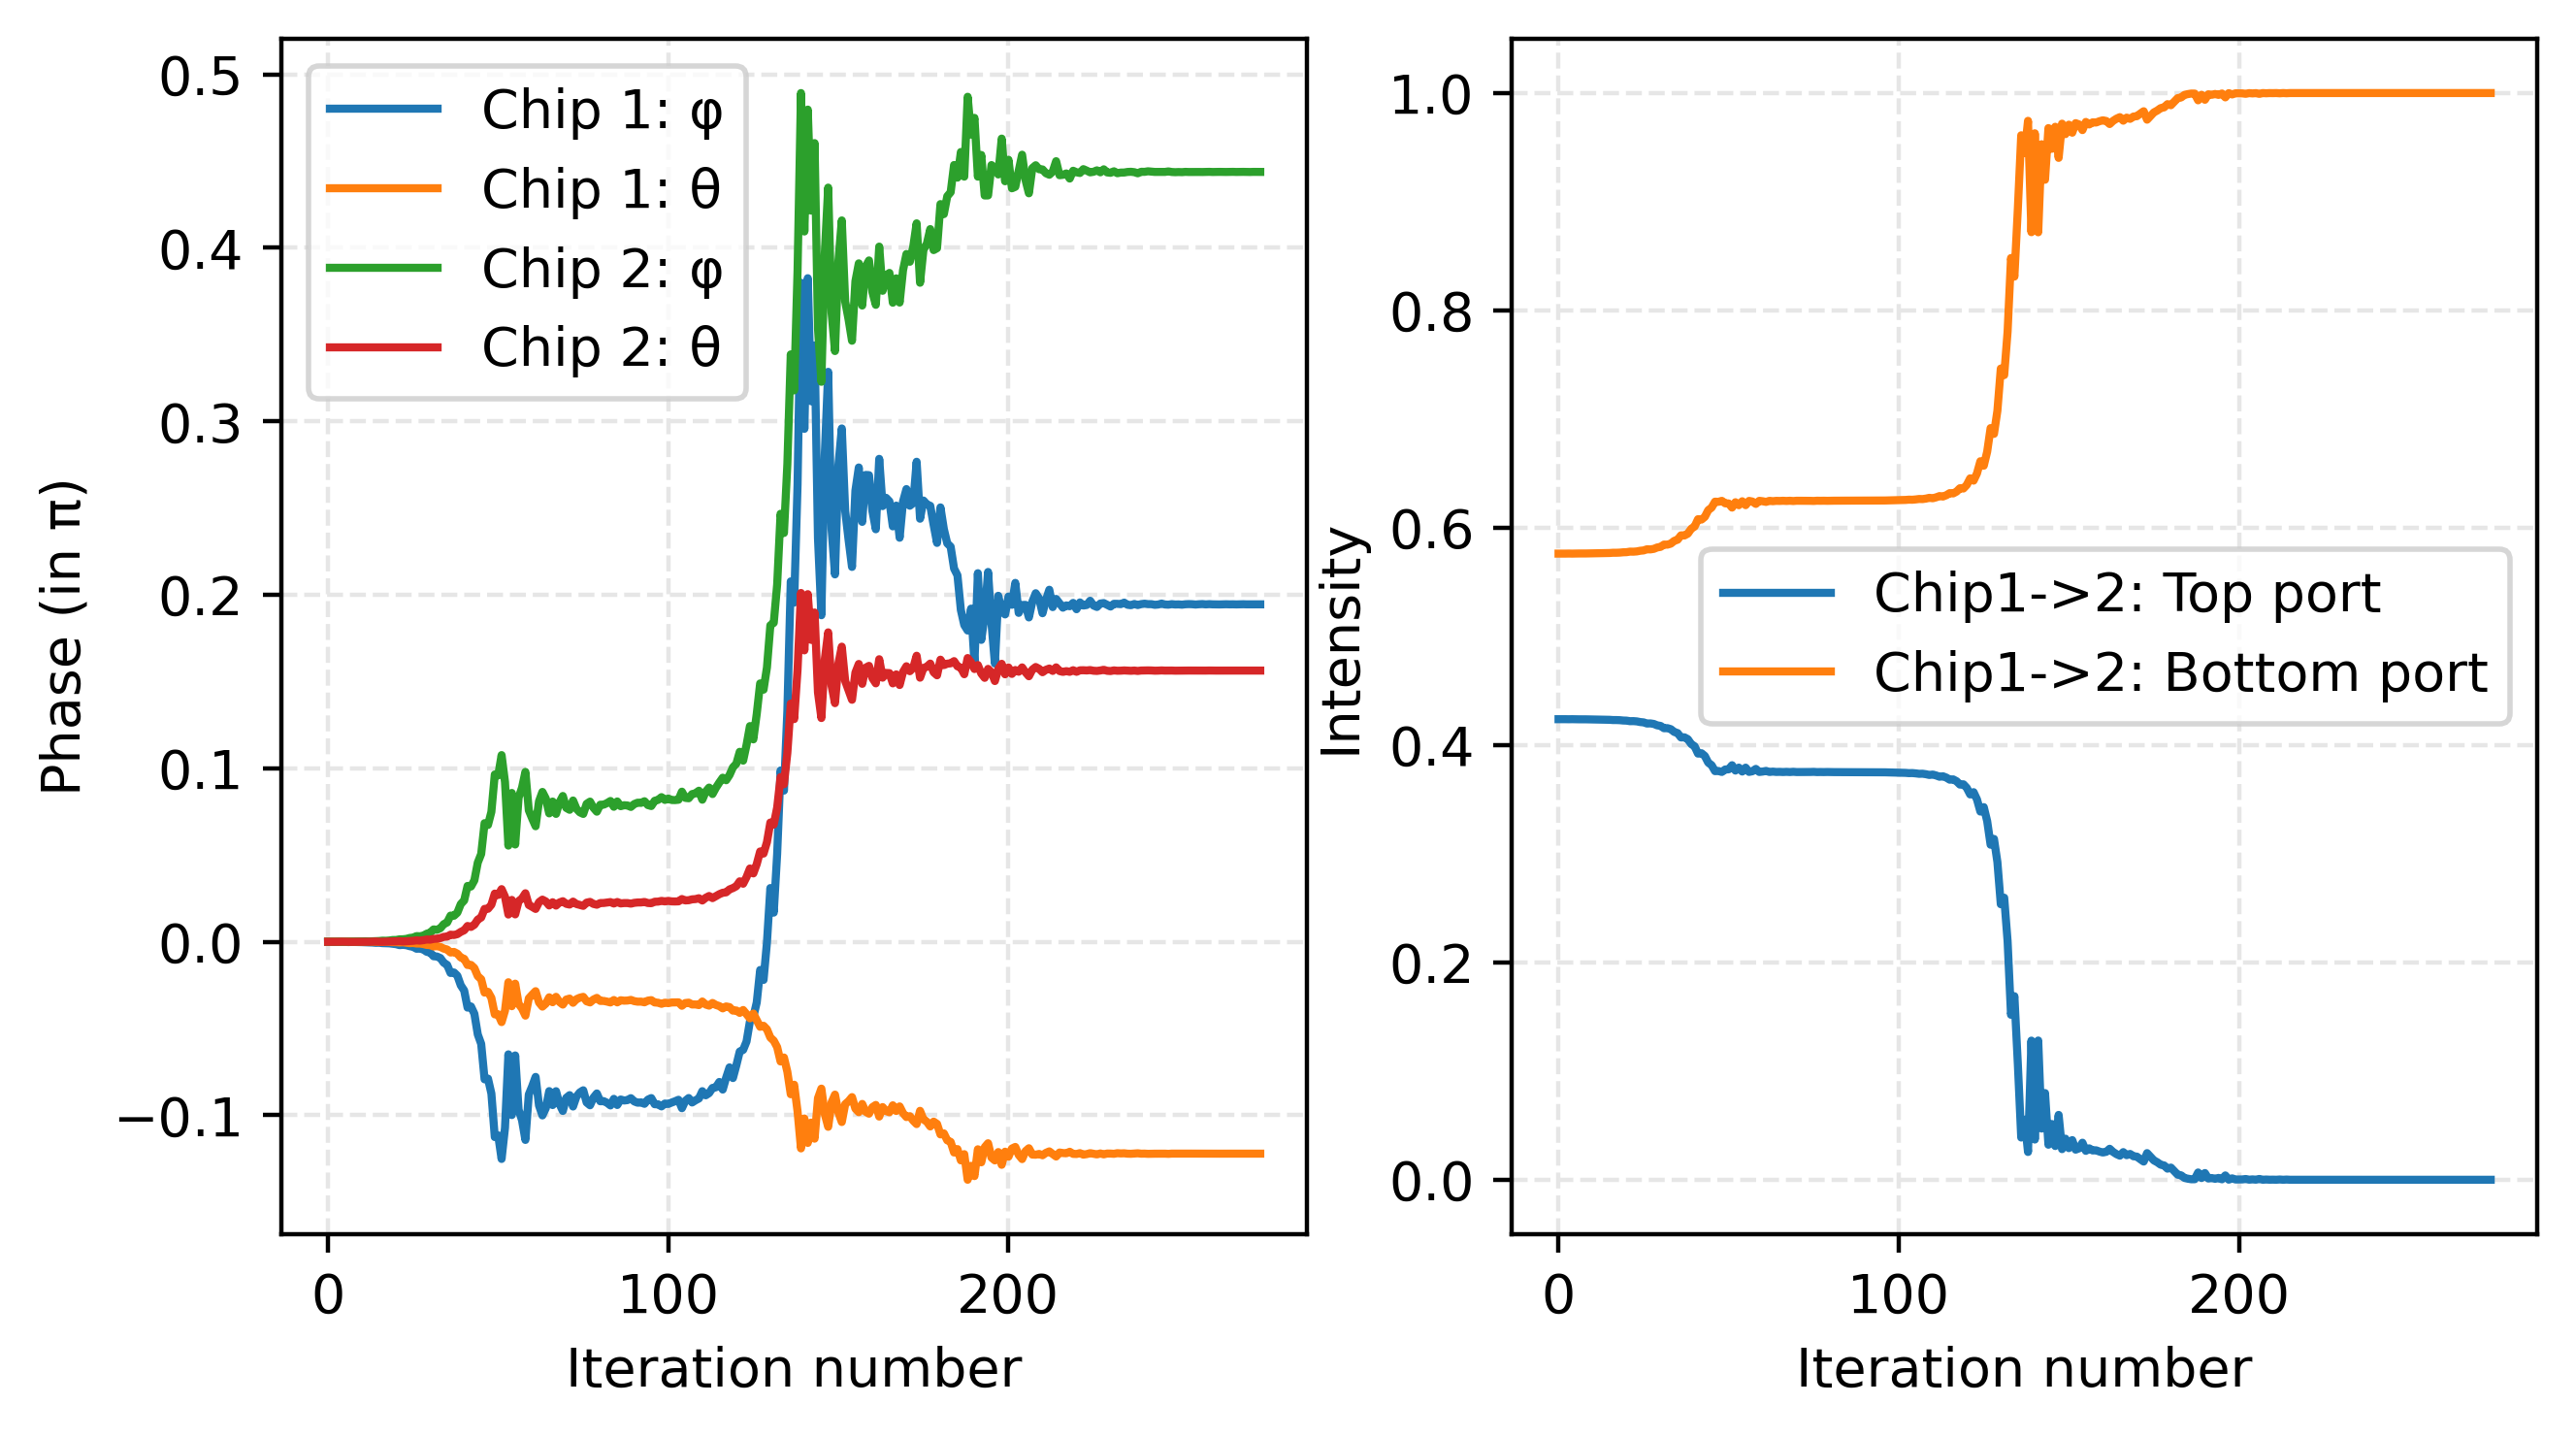

In [7]:

def plot_optimization(params):
    iters = np.arange(len(params))
    params = np.array(params)
    labels = ["Chip 1: φ", "Chip 1: θ", "Chip 2: φ", "Chip 2: θ"]
    plt.figure(figsize=(7.5, 4), dpi=400)
    plt.subplot(1, 2, 1)
    plt.plot(iters, params[:, 0:4]/np.pi, label=labels)
    plt.ylabel('Phase (in π)')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

    labels = [
        "Chip1->2: Top port",
        "Chip1->2: Bottom port"
    ]
    plt.subplot(1, 2, 2)
    plt.plot(iters, params[:, 6:], label=labels)
    plt.ylabel('Intensity')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

plot_optimization(params)  

In [8]:
phase_1 = params[-1][0]  # phase shifter setting
theta_1 = params[-1][1]  # MZI setting
phase_2 = params[-1][2]  # phase shifter setting
theta_2 = params[-1][3]  # MZI setting

mzi_1 = rotation_ry(phase_1)
ps_1 = rotation_rz(theta_1)

mzi_2 = rotation_ry(phase_2)
ps_2 = rotation_rz(theta_2)

In [9]:
print("Final states")
print("MZI 1:\n", mzi_1)
print("Phase Shifter 1:\n", ps_1)
print("MZI 2:\n", mzi_2)
print("Phase Shifter 2:\n", ps_2)
print("Fiber 1:\n", fiber_1)
print("Fiber 2:\n", fiber_2)

Final states
MZI 1:
 [[ 0.95367674 -0.3008333 ]
 [ 0.3008333   0.95367674]]
Phase Shifter 1:
 [[0.98165313+0.19067548j 0.        +0.j        ]
 [0.        +0.j         0.98165313-0.19067548j]]
MZI 2:
 [[ 0.76668522 -0.64202319]
 [ 0.64202319  0.76668522]]
Phase Shifter 2:
 [[0.96999794-0.24311313j 0.        +0.j        ]
 [0.        +0.j         0.96999794+0.24311313j]]
Fiber 1:
 [[ 0.36009285+0.68035537j -0.26303578+0.58160286j]
 [ 0.32179795+0.55126744j  0.28776948-0.71396009j]]
Fiber 2:
 [[-0.24033586+0.38331655j -0.70674061-0.54389779j]
 [-0.69898073+0.55383485j  0.24573091+0.37988054j]]


### Chip 1 to Chip 2 

In [10]:
connector_return_loss = -20 #dB

In [11]:
input_state_forward = np.array([1.0, 0.0])
output_state_forward = mzi_2 @ ps_2 @ fiber_2 @ fiber_1 @ ps_1 @ mzi_1 @ input_state_forward
connector_state_forward = fiber_1 @ ps_1 @ mzi_1 @ input_state_forward
reflected_state_forward = np.sqrt(10**(connector_return_loss/10)) * mzi_1.T @ ps_1.T @ fiber_1.T @ connector_state_forward
print("Output state forward intensity: ", np.abs(output_state_forward)**2, ", state: ", output_state_forward)
print("Connector state forward intensity: ", np.abs(connector_state_forward)**2, ", state: ", connector_state_forward)
print("Reflected state forward intensity: ", np.abs(reflected_state_forward)**2, ", state: ", reflected_state_forward)

Output state forward intensity:  [4.38405005e-10 1.00000000e+00] , state:  [ 1.53793666e-05-1.42084513e-05j -7.52498198e-01-6.58594307e-01j]
Connector state forward intensity:  [0.81936835 0.18063165] , state:  [0.16907743+0.88925878j 0.24504522+0.34725278j]
Reflected state forward intensity:  [0.00898627 0.00101373] , state:  [-0.08227313+0.04708924j -0.00329415-0.03166833j]


### Chip 2 to Chip 1

In [12]:
input_state_reverse = np.array([1.0, 0.0])
output_state_reverse = mzi_1.T @ ps_1.T @ fiber_1.T @ fiber_2.T @ ps_2.T @ mzi_2.T @ input_state_reverse
connector_state_reverse = fiber_2.T @ ps_2.T @ mzi_2.T @ input_state_reverse
reflected_state_reverse = np.sqrt(10**(connector_return_loss/10)) * mzi_2 @ ps_2 @ fiber_2 @ connector_state_reverse
print("Output state reverse intensity: ", np.abs(output_state_reverse)**2, ", state: ", output_state_reverse)
print("Connector state reverse intensity: ", np.abs(connector_state_reverse)**2, ", state: ", connector_state_reverse)
print("Reflected state reverse intensity: ", np.abs(reflected_state_reverse)**2, ", state: ", reflected_state_reverse)

Output state reverse intensity:  [4.38405005e-10 1.00000000e+00] , state:  [ 1.53793666e-05-1.42084513e-05j -6.69890964e-01+7.42459491e-01j]
Connector state reverse intensity:  [0.18062031 0.81937969] , state:  [ 0.41445609+0.09405559j -0.72070711-0.54768691j]
Reflected state reverse intensity:  [0.00898614 0.00101386] , state:  [0.03823852+0.08674075j 0.00045015+0.03183795j]


### Inner products of the states to inspect their orthogonality

In [13]:
print("Inner product (States):")
print("Input: ", np.vdot(input_state_forward, input_state_reverse))
print("Chip 1: ", np.vdot(input_state_forward, output_state_reverse))
print("Chip 2: ", np.vdot(input_state_reverse, output_state_forward))
print("Forward: ", np.vdot(output_state_forward, output_state_reverse))
print("Connector: ", np.vdot(connector_state_forward, connector_state_reverse))
print("Reflected at Chip1: ", np.vdot(reflected_state_forward, input_state_forward))
print("Reflected at Chip2: ", np.vdot(reflected_state_reverse, input_state_reverse))

Inner product (States):
Input:  1.0
Chip 1:  (1.53793665584352e-05-1.4208451346757044e-05j)
Chip 2:  (1.5379366558444642e-05-1.4208451346714518e-05j)
Forward:  (0.015112150324326272-0.9998858045042023j)
Connector:  (-0.2130767027486211-0.23659655568612628j)
Reflected at Chip1:  (-0.08227313233697688-0.047089244681284025j)
Reflected at Chip2:  (0.038238519248058-0.08674075255173239j)


In [14]:
print("Inner product (Intensities):")
print("Input: ", np.vdot(np.abs(input_state_forward)**2, np.abs(input_state_reverse)**2))
print("Chip 1: ", np.vdot(np.abs(input_state_forward)**2, np.abs(output_state_reverse)**2))
print("Chip 2: ", np.vdot(np.abs(input_state_reverse)**2, np.abs(output_state_forward)**2))
print("Forward: ", np.vdot(np.abs(output_state_forward)**2, np.abs(output_state_reverse)**2))
print("Connector: ", np.vdot(np.abs(connector_state_forward)**2, np.abs(connector_state_reverse)**2))
print("Reflected at Chip1: ", np.vdot(np.abs(reflected_state_forward)**2, np.abs(input_state_forward)))
print("Reflected at Chip2: ", np.vdot(np.abs(reflected_state_reverse)**2, np.abs(input_state_reverse)))

Inner product (Intensities):
Input:  1.0
Chip 1:  4.384050054118769e-10
Chip 2:  4.3840500541095896e-10
Forward:  0.99999999912319
Connector:  0.2960004696682708
Reflected at Chip1:  0.008986265269191548
Reflected at Chip2:  0.00898614250752497


# Polarization Receiver only on TX

In [15]:
mzi_1 = rotation_ry(0.0)
ps_1 = rotation_rz(0.0)

fiber_1 = jones_matrix(np.random.uniform(-np.pi, np.pi, 4))
fiber_2 = jones_matrix(np.random.uniform(-np.pi, np.pi, 4))

In [16]:
print("Initial states")
print("MZI 1:\n", mzi_1)
print("Phase Shifter 1:\n", ps_1)
print("Fiber 1:\n", fiber_1)
print("Fiber 2:\n", fiber_2)

Initial states
MZI 1:
 [[ 1. -0.]
 [ 0.  1.]]
Phase Shifter 1:
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Fiber 1:
 [[-0.89714147-0.10456181j -0.35846214-0.23602733j]
 [-0.15502961+0.40021222j  0.67005373-0.60565997j]]
Fiber 2:
 [[-0.57666257-0.45950492j -0.16308348+0.65552978j]
 [ 0.5632396 +0.37292983j -0.11446478+0.72841081j]]


In [17]:
def objective_reverse(phases, input_state, params):
    """
    The objective function here is just maximize the received signal in the
    RX of port 2
    """
    phase_1 = phases[0]  # phase shifter setting
    theta_1 = phases[1]  # MZI setting

    mzi_1 = rotation_ry(phase_1)
    ps_1 = rotation_rz(theta_1)

    output_state_reverse = mzi_1.T@ ps_1.T @ fiber_1.T @ fiber_2.T @ input_state
    
    I_top_port = np.abs(output_state_reverse[0])**2
    I_bottom_port = np.abs(output_state_reverse[1])**2

    intensities = [I_top_port, I_bottom_port]
    curr_params = [phase_1, theta_1] + [output_state_reverse[0], output_state_reverse[1]] + intensities
    params.append(curr_params)

    return -1.0 * intensities[-1]  # maximize the receiving port power

In [18]:
input_state_reverse = np.array([1.0, 0.0])

bounds = [(-math.pi, math.pi), (-math.pi, math.pi)]

opts = {'fatol': 1e-6}
params = []
result = minimize(objective_reverse, (0.0, 0.0),
                  bounds=bounds,
                  args=(input_state_reverse, params),
                  method='Nelder-Mead',
                  options=opts)

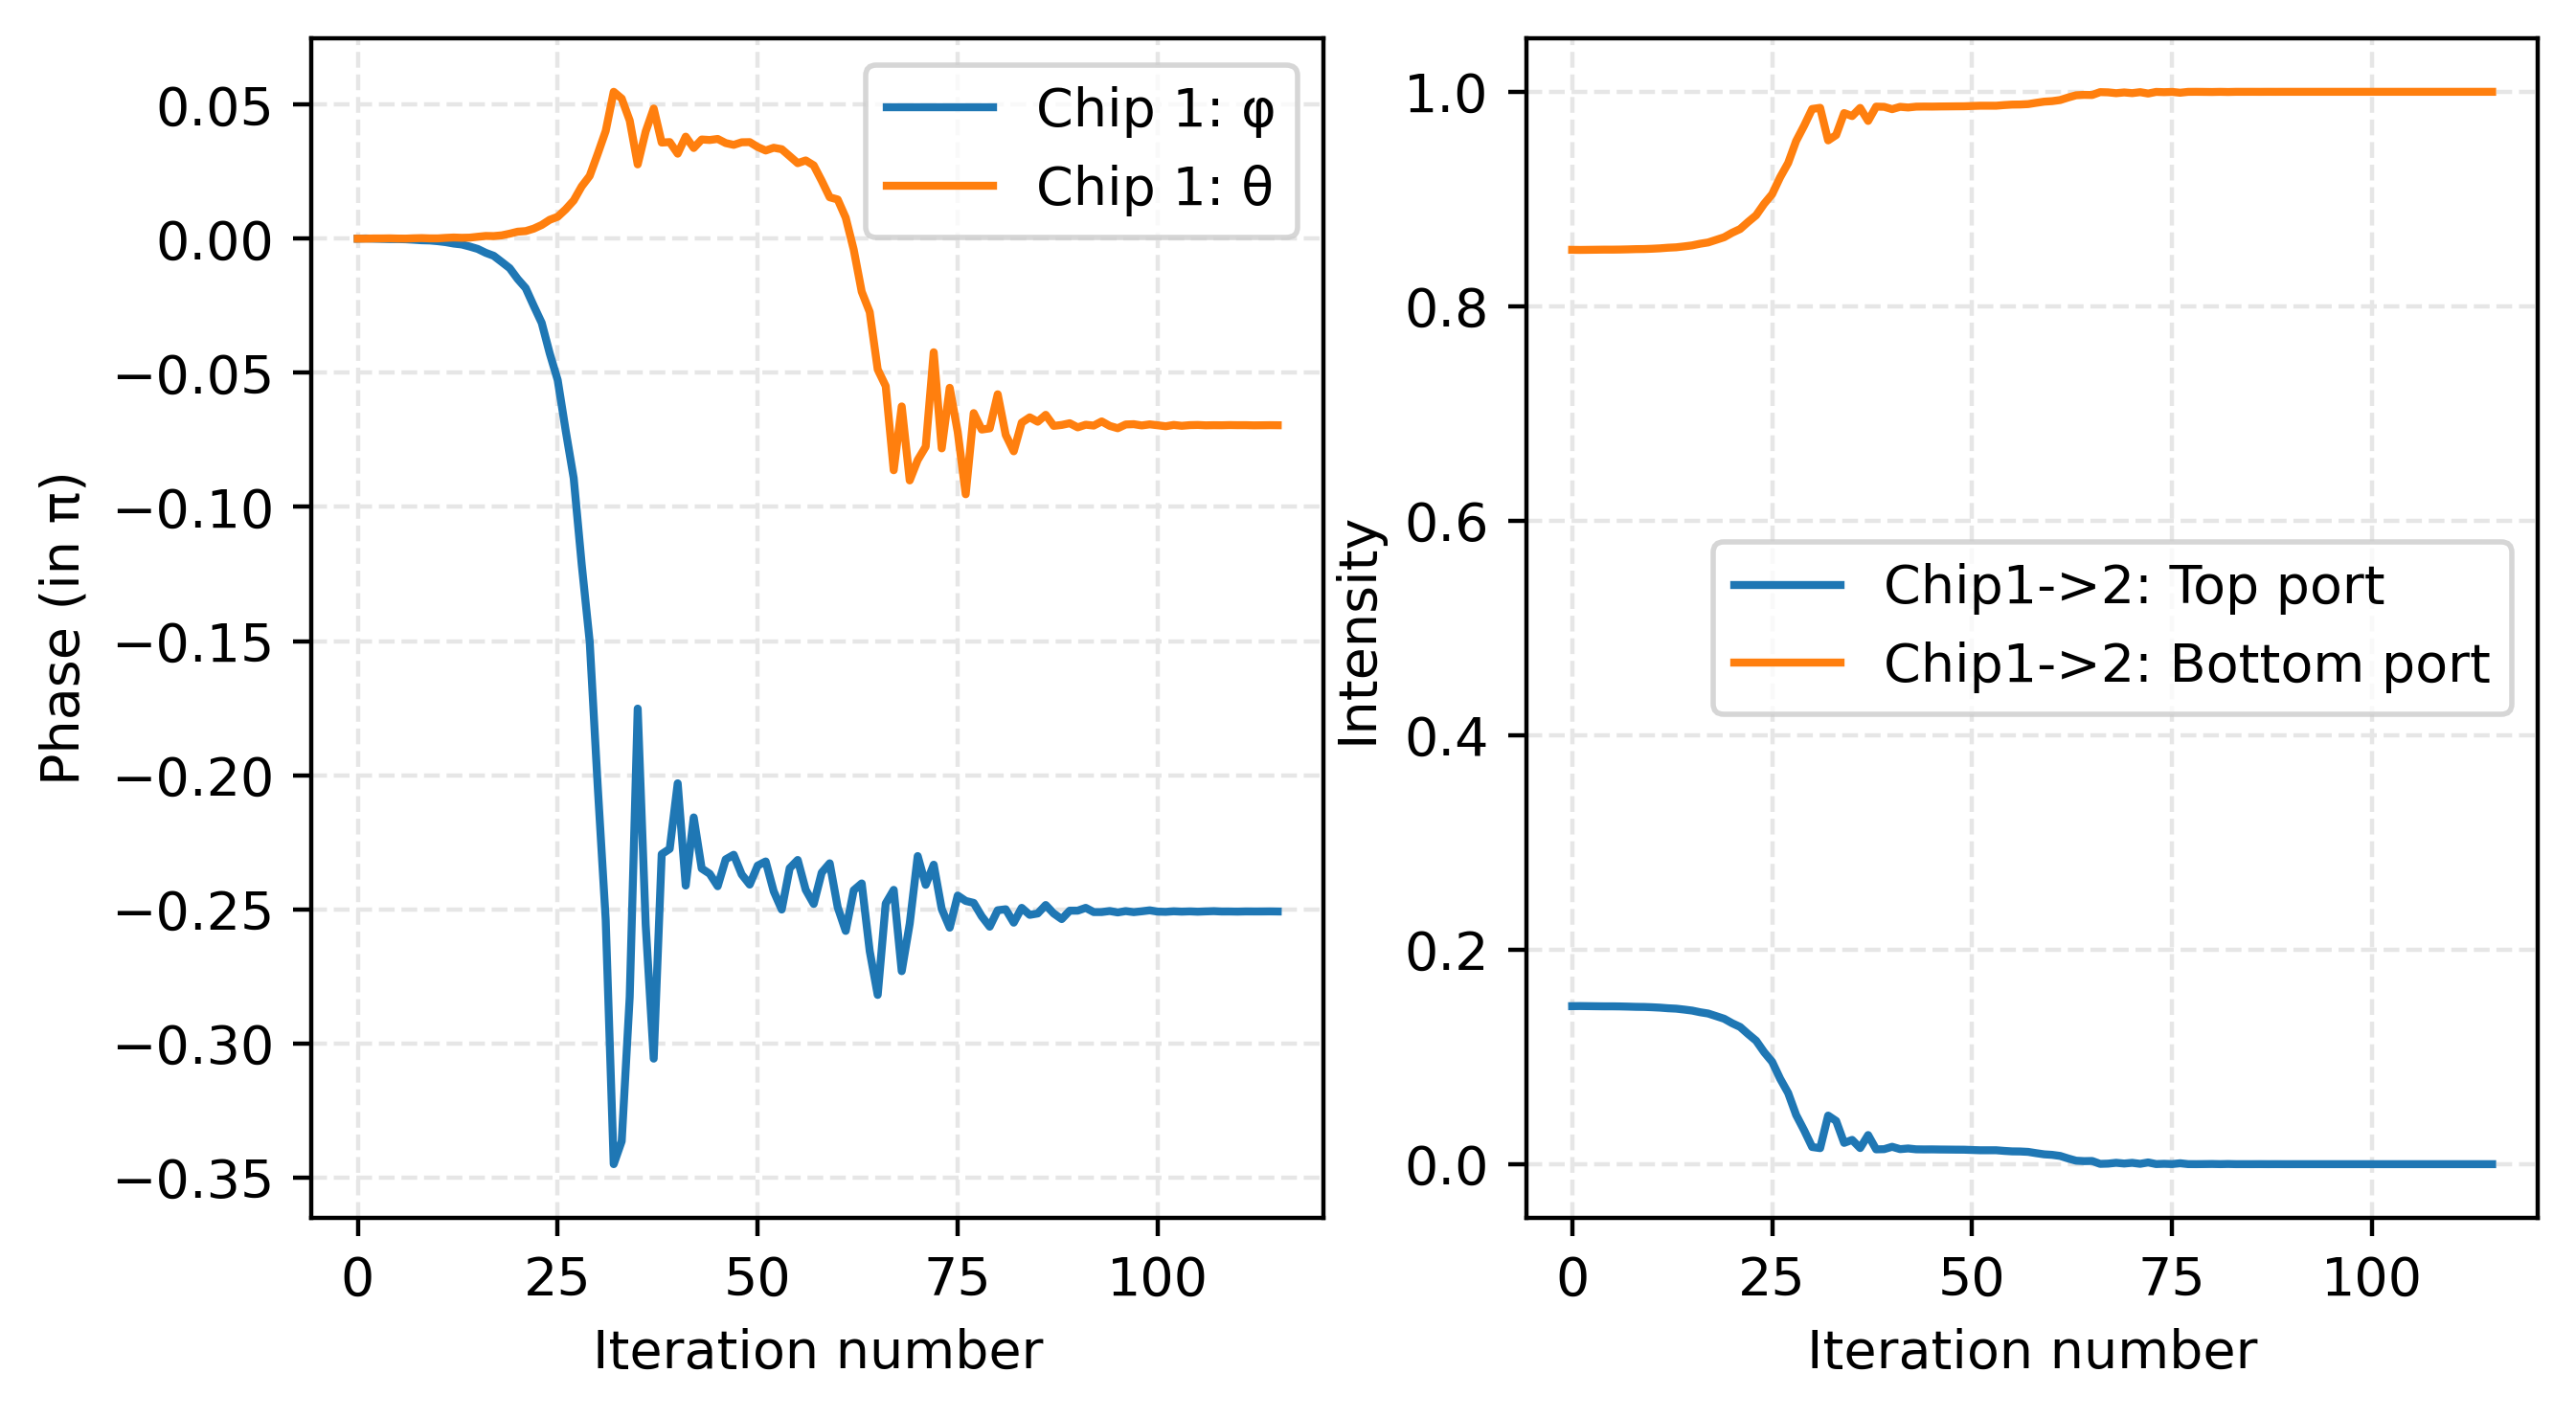

In [19]:

def plot_optimization(params):
    iters = np.arange(len(params))
    params = np.array(params)
    labels = ["Chip 1: φ", "Chip 1: θ"]
    plt.figure(figsize=(7.5, 4), dpi=400)
    plt.subplot(1, 2, 1)
    plt.plot(iters, params[:, 0:2]/np.pi, label=labels)
    plt.ylabel('Phase (in π)')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

    labels = [
        "Chip1->2: Top port",
        "Chip1->2: Bottom port"
    ]
    plt.subplot(1, 2, 2)
    plt.plot(iters, params[:, 4:], label=labels)
    plt.ylabel('Intensity')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

plot_optimization(params)  

In [20]:
phase_1 = params[-1][0]  # phase shifter setting
theta_1 = params[-1][1]  # MZI setting

mzi_1 = rotation_ry(phase_1)
ps_1 = rotation_rz(theta_1)

In [21]:
print("Final states")
print("MZI 1:\n", mzi_1)
print("Phase Shifter 1:\n", ps_1)
print("Fiber 1:\n", fiber_1)
print("Fiber 2:\n", fiber_2)

Final states
MZI 1:
 [[ 0.92338762  0.38386886]
 [-0.38386886  0.92338762]]
Phase Shifter 1:
 [[0.99403782+0.10903587j 0.        +0.j        ]
 [0.        +0.j         0.99403782-0.10903587j]]
Fiber 1:
 [[-0.89714147-0.10456181j -0.35846214-0.23602733j]
 [-0.15502961+0.40021222j  0.67005373-0.60565997j]]
Fiber 2:
 [[-0.57666257-0.45950492j -0.16308348+0.65552978j]
 [ 0.5632396 +0.37292983j -0.11446478+0.72841081j]]


### Chip 1 to Chip 2 

In [22]:
connector_return_loss = -20 #dB

In [27]:
input_state_forward = np.array([1.0, 0.0])
output_state_forward = fiber_2 @ fiber_1 @ ps_1 @ mzi_1 @ input_state_forward
before_fiber_state_forward = ps_1 @ mzi_1 @ input_state_forward
connector_state_forward = fiber_1 @ ps_1 @ mzi_1 @ input_state_forward
reflected_state_forward =  (mzi_1.T @ ps_1.T @ fiber_1.T @ connector_state_forward) #* np.sqrt(10**(connector_return_loss/10))
print("Output state forward intensity: ", np.abs(output_state_forward)**2, ", state: ", output_state_forward)
print("Before fiber state forward intensity:", np.abs(before_fiber_state_forward)**2, ", state: ", before_fiber_state_forward)
print("Connector state forward intensity: ", np.abs(connector_state_forward)**2, ", state: ", connector_state_forward)
print("Reflected state forward intensity: ", np.abs(reflected_state_forward)**2, ", state: ", reflected_state_forward)

Output state forward intensity:  [1.90846326e-10 1.00000000e+00] , state:  [-1.38060518e-05-4.89142041e-07j -7.31506131e-01-6.81834863e-01j]
Before fiber state forward intensity: [0.8526447 0.1473553] , state:  [ 0.91788221+0.10068237j -0.38158016+0.04185547j]
Connector state forward intensity:  [0.45630595 0.54369405] , state:  [-0.66628159-0.111242j   -0.41292226+0.61089218j]
Reflected state forward intensity:  [0.17930708 0.82069292] , state:  [0.22887192-0.35626496j 0.52558853+0.73786829j]


### Chip 2 to Chip 1

In [30]:
input_state_reverse = np.array([1.0, 0.0])
output_state_reverse = mzi_1.T @ ps_1.T @ fiber_1.T @ fiber_2.T @ input_state_reverse
connector_state_reverse = fiber_2.T @ input_state_reverse
reflected_state_reverse =  fiber_2 @ connector_state_reverse # * np.sqrt(10**(connector_return_loss/10))
after_fiber_state_reverse = fiber_1.T @ fiber_2.T @ input_state_reverse
print("Output state reverse intensity: ", np.abs(output_state_reverse)**2, ", state: ", output_state_reverse)
print("After fiber state reverse intensity: ", np.abs(after_fiber_state_reverse)**2, ", state:", after_fiber_state_reverse)
print("Connector state reverse intensity: ", np.abs(connector_state_reverse)**2, ", state: ", connector_state_reverse)
print("Reflected state reverse intensity: ", np.abs(reflected_state_reverse)**2, ", state: ", reflected_state_reverse)

Output state reverse intensity:  [1.90846326e-10 1.00000000e+00] , state:  [-1.38060518e-05-4.89142041e-07j  5.14589895e-01+8.57436435e-01j]
After fiber state reverse intensity:  [0.14734997 0.85265003] , state: [0.23223298+0.30564327j 0.38600943+0.83883655j]
Connector state reverse intensity:  [0.54368449 0.45631551] , state:  [-0.57666257-0.45950492j -0.16308348+0.65552978j]
Reflected state reverse intensity:  [0.17931929 0.82068071] , state:  [-0.28172812+0.31614643j -0.61226377-0.66769288j]


### Inner products of the states to inspect their orthogonality

In [31]:
print("Inner product (States):")
print("Input: ", np.vdot(input_state_forward, input_state_reverse))
print("Chip 1: ", np.vdot(input_state_forward, output_state_reverse))
print("Chip 2: ", np.vdot(input_state_reverse, output_state_forward))
print("Forward: ", np.vdot(output_state_forward, output_state_reverse))
print("Connector: ", np.vdot(connector_state_forward, connector_state_reverse))
print("Before fiber:", np.vdot(before_fiber_state_forward, after_fiber_state_reverse))
print("Reflected at Chip1: ", np.vdot(reflected_state_forward, input_state_forward))
print("Reflected at Chip2: ", np.vdot(reflected_state_reverse, input_state_reverse))

Inner product (States):
Input:  1.0
Chip 1:  (-1.3806051808610473e-05-4.891420410377448e-07j)
Chip 2:  (-1.3806051808596905e-05-4.891420411399193e-07j)
Forward:  (-0.9610557168671972-0.2763546784991288j)
Connector:  (0.9031347187333508+0.07095415401354799j)
Before fiber: (0.13175177333445884-0.07907723767061291j)
Reflected at Chip1:  (0.22887192081143995+0.35626496449586353j)
Reflected at Chip2:  (-0.28172811834902073-0.3161464254074665j)


In [32]:
print("Inner product (Intensities):")
print("Input: ", np.vdot(np.abs(input_state_forward)**2, np.abs(input_state_reverse)**2))
print("Chip 1: ", np.vdot(np.abs(input_state_forward)**2, np.abs(output_state_reverse)**2))
print("Chip 2: ", np.vdot(np.abs(input_state_reverse)**2, np.abs(output_state_forward)**2))
print("Forward: ", np.vdot(np.abs(output_state_forward)**2, np.abs(output_state_reverse)**2))
print("Connector: ", np.vdot(np.abs(connector_state_forward)**2, np.abs(connector_state_reverse)**2))
print("Before fiber:", np.vdot(np.abs(before_fiber_state_forward)**2, np.abs(after_fiber_state_reverse)**2))
print("Reflected at Chip1: ", np.vdot(np.abs(reflected_state_forward)**2, np.abs(input_state_forward)))
print("Reflected at Chip2: ", np.vdot(np.abs(reflected_state_reverse)**2, np.abs(input_state_reverse)))

Inner product (Intensities):
Input:  1.0
Chip 1:  1.9084632647834708e-10
Chip 2:  1.9084632647807237e-10
Forward:  0.9999999996183071
Connector:  0.4961824949484739
Before fiber: 0.2512796712740968
Reflected at Chip1:  0.179307081063157
Reflected at Chip2:  0.17931929496639865
